# Experiment of Hybrid Ensemble Malware Detection (PHMM + Stacked Classifier) - 
<em> Reference: https://github.com/delphi20/Malware-Detection-with-ML-DL-/blob/main </em>

### Importing the dataset

In [22]:

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
# import shap
# shap.initjs()

# Step 1: Load the data
benign_df = pd.read_csv('benign_samples.csv')   # CSV with benign samples
malware_df = pd.read_csv('malware_samples.csv') # CSV with malware samples

# Step 2: Label the data
benign_df['label'] = 0  # Label all benign samples as 0
malware_df['label'] = 1  # Label all malware samples as 1

### Discretising to create observation sequences

In [23]:
from sklearn.cluster import KMeans

features_malware = malware_df.iloc[:,3:-2]

kmeans = KMeans(n_clusters=5)

df_discretized = features_malware.apply(lambda x: kmeans.fit_predict(x.values.reshape(-1, 1)))

malware_df['Observation_Sequence'] = df_discretized.apply(lambda row: ','.join(map(str, row)), axis=1)

malware_df.head()


features_benign = benign_df.iloc[:,3:-2]
features_benign.head()

kmeans_b = KMeans(n_clusters=5)

df_discretized = features_benign.apply(lambda x: kmeans_b.fit_predict(x.values.reshape(-1, 1)))

benign_df['Observation_Sequence'] = df_discretized.apply(lambda row: ','.join(map(str, row)), axis=1)

benign_df.head()

c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class,label,Observation_Sequence
0,Benign,2018,March,45,17,10.555556,0,202.844444,1694,38.500000,...,24,116,0,121,87,0,8,Benign,0,"2,1,3,0,0,0,2,3,3,0,4,4,0,1,4,0,0,1,2,2,4,2,0,..."
1,Benign,2018,March,47,19,11.531915,0,242.234043,2074,44.127660,...,24,118,0,122,87,0,8,Benign,0,"2,2,1,0,0,4,2,1,3,0,1,0,0,0,2,1,3,2,0,4,2,0,4,..."
2,Benign,2018,March,40,14,14.725000,0,288.225000,1932,48.300000,...,27,118,0,120,88,0,8,Benign,0,"0,3,0,0,3,0,4,1,4,0,0,0,4,1,1,0,0,0,0,0,4,2,0,..."
3,Benign,2018,March,32,13,13.500000,0,264.281250,1445,45.156250,...,27,118,0,120,88,0,8,Benign,0,"4,4,4,0,2,3,0,3,0,0,4,4,2,4,4,4,2,1,2,2,0,3,3,..."
4,Benign,2018,March,42,16,11.452381,0,281.333333,2067,49.214286,...,24,118,0,124,87,0,8,Benign,0,"0,1,1,0,3,4,4,0,4,0,1,0,4,2,2,0,1,1,0,1,3,4,2,..."


### Training seperate markov models

Malware samples markov model

In [24]:
import numpy as np
from hmmlearn import hmm

# Extract sequences of observations for each sample
sequences_malware = [list(map(int, seq.split(','))) for seq in malware_df['Observation_Sequence']]
lengths = [len(seq) for seq in sequences_malware]

# Train HMM (use GaussianHMM if continuous or MultinomialHMM if discrete)
model_malware = hmm.MultinomialHMM(n_components=3, n_iter=100)  # 3 hidden states
X = np.concatenate(sequences_malware).reshape(-1, 1)

# Train the HMM on the observation sequences
model_malware.fit(X, lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=3, n_iter=100,
               n_trials=array([3, 1, 1, ..., 2, 0, 0], shape=(1587850,)),
               random_state=RandomState(MT19937) at 0x2A6F7813C40)

Benign samples model

In [25]:
# Extract sequences of observations for each sample
sequences_benign = [list(map(int, seq.split(','))) for seq in benign_df['Observation_Sequence']]
lengths = [len(seq) for seq in sequences_benign]

# Train HMM (use GaussianHMM if continuous or MultinomialHMM if discrete)
model_benign = hmm.MultinomialHMM(n_components=3, n_iter=100)  # 3 hidden states
X = np.concatenate(sequences_benign).reshape(-1, 1)

# Train the HMM on the observation sequences
model_benign.fit(X, lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=3, n_iter=100,
               n_trials=array([2, 1, 3, ..., 0, 0, 0], shape=(1611390,)),
               random_state=RandomState(MT19937) at 0x2A6F7813C40)

Metrics, change model var to display as necessary

In [26]:
# log_likelihood = model.score(X)
# print(f"Log Likelihood: {log_likelihood}")


# print("Number of hidden states:", model.n_components)


# print("Maximum iterations:", model.n_iter)
# print("Did the model converge?", model.monitor_.converged, "\n\n")

# print("Transition matrix (A):")
# print(model.transmat_)

# print("\n\nEmission probabilities (B):")
# print(model.emissionprob_)


# print("\n\nInitial state probabilities (π):")
# print(model.startprob_)

In [27]:
# params = model.get_params()
# print("HMM Parameters:")
# print(params)

Adding the scores to the dataframes

In [28]:
def add_hmm_scores(df_m, df_b, benign_hmm, malware_hmm):
    # Convert sequences to proper format for HMM
    sequences_m = [list(map(int, seq.split(','))) for seq in df_m['Observation_Sequence']]
    sequences_b = [list(map(int, seq.split(','))) for seq in df_b['Observation_Sequence']]

    # Calculate scores for each sequence
    malware_scores = []
    for seq in sequences_m:
        # Reshape the sequence and compute the score
        score = malware_hmm.score(np.array(seq).reshape(-1, 1))
        malware_scores.append(score)

    benign_scores = []
    for seq in sequences_b:
        # Reshape the sequence and compute the score
        score = benign_hmm.score(np.array(seq).reshape(-1, 1))
        benign_scores.append(score)

    # Add scores as new columns
    df_m['malware_hmm_score'] = malware_scores
    df_b['benign_hmm_score'] = benign_scores

    return df_m, df_b

# Add scores to train and test dataframes
malware_df, benign_df = add_hmm_scores(malware_df, benign_df, model_benign, model_malware)

Check dataframes

In [29]:
malware_df.head()

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class,label,Observation_Sequence,malware_hmm_score
0,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,11.410256,0,220.589744,1562,40.051282,...,116,0,122,87,0,8,Malware,1,"3,1,1,0,0,0,0,0,0,0,0,1,2,0,2,2,1,0,0,0,4,0,0,...",6.605827e-15
1,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,37,15,10.135135,0,214.648649,1445,39.054054,...,116,0,119,87,0,8,Malware,1,"3,1,0,0,0,4,0,0,0,0,0,3,2,0,1,0,4,4,0,1,0,4,0,...",6.605827e-15
2,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,10.743590,0,217.410256,1551,39.769231,...,116,0,122,87,0,8,Malware,1,"3,1,0,0,0,0,0,0,0,0,0,1,2,0,4,2,1,0,0,0,4,0,0,...",6.605827e-15
3,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,41,16,10.121951,0,210.170732,1614,39.365854,...,116,0,122,87,0,8,Malware,1,"0,1,0,0,0,2,0,0,0,0,0,1,0,0,4,1,1,2,0,0,0,0,0,...",6.605827e-15
4,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,40,16,9.875000,0,208.650000,1556,38.900000,...,116,0,122,87,0,8,Malware,1,"0,1,2,0,0,0,0,0,0,0,0,3,2,0,1,2,4,0,0,0,0,0,0,...",6.605827e-15


Reorder columns

In [30]:
# Swap the last two columns with the two columns before them
cols = malware_df.columns.tolist()
# Swap the last two with the two before them
cols[-4:-2], cols[-2:] = cols[-2:], cols[-4:-2]

# Reorder the DataFrame using the new column order
malware_df = malware_df[cols]

malware_df.head()

# Swap the last two columns with the two columns before them
cols = benign_df.columns.tolist()
# Swap the last two with the two before them
cols[-4:-2], cols[-2:] = cols[-2:], cols[-4:-2]

# Reorder the DataFrame using the new column order
benign_df = benign_df[cols]

malware_df.head()

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Observation_Sequence,malware_hmm_score,Class,label
0,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,11.410256,0,220.589744,1562,40.051282,...,116,0,122,87,0,8,"3,1,1,0,0,0,0,0,0,0,0,1,2,0,2,2,1,0,0,0,4,0,0,...",6.605827e-15,Malware,1
1,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,37,15,10.135135,0,214.648649,1445,39.054054,...,116,0,119,87,0,8,"3,1,0,0,0,4,0,0,0,0,0,3,2,0,1,0,4,4,0,1,0,4,0,...",6.605827e-15,Malware,1
2,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,10.743590,0,217.410256,1551,39.769231,...,116,0,122,87,0,8,"3,1,0,0,0,0,0,0,0,0,0,1,2,0,4,2,1,0,0,0,4,0,0,...",6.605827e-15,Malware,1
3,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,41,16,10.121951,0,210.170732,1614,39.365854,...,116,0,122,87,0,8,"0,1,0,0,0,2,0,0,0,0,0,1,0,0,4,1,1,2,0,0,0,0,0,...",6.605827e-15,Malware,1
4,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,40,16,9.875000,0,208.650000,1556,38.900000,...,116,0,122,87,0,8,"0,1,2,0,0,0,0,0,0,0,0,3,2,0,1,2,4,0,0,0,0,0,0,...",6.605827e-15,Malware,1


Temporal test train splitting

In [31]:
# Step 3: Concatenate both datasets
combined_df = pd.concat([benign_df, malware_df])

# Step 4: Shuffle the combined data
shuffled_df = shuffle(combined_df, random_state=42)
shuffled_df["Year "].isnull().sum()

# fill nan values
cols = shuffled_df[-2:]
shuffled_df= shuffled_df.fillna(0)


train_df = shuffled_df[shuffled_df['Year ']<2020]
test_df = shuffled_df[shuffled_df['Year ']>=2020]

train_df.tail()

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Observation_Sequence,benign_hmm_score,Class,label,malware_hmm_score
14833,Spyware-Transponder-0db5d3ce56c256bd8fb7e2ef9f...,2019,August,39,15,9.948718,0,210.461538,1521,39.000000,...,0,121,87,0,8,"3,1,0,0,0,0,0,0,0,0,0,3,2,0,1,2,4,0,0,0,0,4,0,...",0.000000e+00,Malware,1,6.605827e-15
21962,Benign,2011,July,41,16,11.402015,0,260.252561,1821,44.426406,...,0,126,87,0,8,"0,1,1,0,2,0,2,1,0,0,1,0,4,3,4,0,0,1,0,4,1,0,1,...",-8.826273e-15,Benign,0,0.000000e+00
7896,Spyware-180solutions-1ab4f5e85c9e0c623dabf7455...,2018,March,47,20,9.000000,0,191.659574,1766,37.574468,...,0,123,87,0,8,"0,0,2,0,2,2,3,0,4,0,0,4,0,4,4,1,1,2,0,0,4,3,2,...",0.000000e+00,Malware,1,6.605827e-15
25045,Trojan-Zeus-3fcd417ca419e8db29f16121a698e7c631...,2018,June,38,15,10.000000,0,211.921053,1481,38.973684,...,0,122,87,0,8,"3,1,0,0,0,4,0,0,0,0,0,3,2,0,1,0,4,4,0,1,0,4,0,...",0.000000e+00,Malware,1,6.605827e-15
15795,Benign,2019,May,51,20,11.485621,0,254.858328,2295,44.918269,...,0,126,87,0,8,"2,2,1,0,0,1,2,0,3,0,0,2,1,0,1,1,1,2,1,4,1,4,1,...",-8.826273e-15,Benign,0,0.000000e+00


code that prints number of samples that are past the year 2020, and all that are before

In [32]:
# Samples with Year > 2020
count_after_2020 = (shuffled_df["Year "] > 2020).sum()
print("Samples after 2020:", count_after_2020)

# Samples with Year <= 2020
count_before_or_in_2020 = (shuffled_df["Year "] <= 2020).sum()
print("Samples in or before 2020:", count_before_or_in_2020)

Samples after 2020: 5951
Samples in or before 2020: 52217


Label encode the month column

In [33]:
train_df_features = train_df.iloc[:, 1:-3]
train_df_labels = train_df.iloc[:,-2]

test_df_features = test_df.iloc[:,1:-3]
test_df_labels = test_df.iloc[:,-2]

train_df_labels.head()

4208     1
23742    1
17541    1
20995    1
21953    1
Name: label, dtype: int64

In [34]:
print(train_df.iloc[:, 1:-5].index.equals(train_df.iloc[:, -2:].index))

True


Fixing messed up values in month column

In [35]:
train_df_features['Month'].unique()

array(['March', 'June', 'May', 'April', 'September ', 'November ',
       'January', 'Jan', 'February', 'November', 'Devember', 'October ',
       'December', 'December ', 'October', 'August ', 'August', 'July',
       'June ', 'September', 'Dember ', 'Dececmber ', 'november ', 'Marh',
       'February ', 'Novembber', 'March ', 'July ', ' May', 'September  ',
       'mAY'], dtype=object)

In [36]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Define a mapping for misspelled and inconsistent month values
month_corrections = {
    'January': 'January', 'Jan': 'January',
    'February': 'February', 'February ': 'February',
    'March': 'March', 'Marh': 'March', 'March ': 'March',
    'April': 'April',
    'May': 'May', ' May': 'May', 'mAY': 'May',
    'June': 'June', 'June ': 'June',
    'July': 'July', 'July ': 'July',
    'August': 'August', 'August ': 'August',
    'September': 'September', 'September ': 'September', 'September  ': 'September',
    'October': 'October', 'October ': 'October',
    'November': 'November', 'November ': 'November', 'Novembber': 'November', 'november ': 'November',
    'December': 'December', 'December ': 'December', 'Dececmber ': 'December', 'Devember': 'December', 'Dember ': 'December'
}

# Clean the column by stripping extra spaces, converting to title case, and mapping values
train_df_features['Month'] = train_df_features['Month'].str.strip().str.title()  # Remove extra spaces and ensure proper case
train_df_features['Month'] = train_df_features['Month'].map(month_corrections)  # Map corrected values

imputer = SimpleImputer(strategy='most_frequent')

# Fix: Extract the first column (ravel()) from the 2D array returned by fit_transform
train_df_features['Month'] = imputer.fit_transform(train_df_features[['Month']]).ravel()

# Verify unique values after cleaning
print(train_df_features['Month'].unique())
print(train_df_features['Month'].isna().sum())

# Apply same to test features dataset
test_df_features['Month'] = test_df_features['Month'].str.strip().str.title()
test_df_features['Month'] = test_df_features['Month'].map(month_corrections)

# For the test data, we should use transform() instead of fit_transform() to use the same imputer
test_df_features['Month'] = imputer.transform(test_df_features[['Month']]).ravel()

print(test_df_features['Month'].unique())
print(test_df_features['Month'].isna().sum())

['March' 'June' 'May' 'April' 'September' 'November' 'January' 'February'
 'December' 'October' 'August' 'July']
0
['May' 'April' 'November' 'February' 'December' 'August' 'June' 'January'
 'July' 'September' 'March']
0


Label encoding the month columns

In [37]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Transform the datasets
train_df_features['Month'] = label_encoder.fit_transform(train_df_features['Month'])
test_df_features['Month'] = label_encoder.fit_transform(test_df_features['Month'])

train_df_features.head()

,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,...,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Observation_Sequence,benign_hmm_score
4208,2016,7,39,15,11.076923,0,220.717949,1559,39.974359,8608,...,26,24,116,0,123,87,0,8,"3,1,1,0,0,0,0,0,0,0,0,1,2,0,2,2,1,0,0,0,4,0,0,...",0.0
23742,2018,6,39,15,10.769231,0,217.769231,1558,39.948718,8493,...,26,24,116,0,123,87,0,8,"3,1,0,0,0,0,0,0,0,0,0,1,2,0,4,2,1,0,0,0,0,0,0,...",0.0
17541,2019,8,41,16,10.219512,0,211.243902,1622,39.560976,8661,...,26,24,116,0,123,86,0,8,"0,1,0,0,0,2,0,0,0,0,0,1,0,0,4,1,1,2,0,0,4,0,0,...",0.0
20995,2011,0,38,15,9.842105,0,209.552632,1447,38.078947,7964,...,26,24,116,0,119,86,0,8,"3,1,2,0,0,4,3,0,0,0,0,3,2,0,1,0,4,4,0,1,0,4,0,...",0.0
21953,2012,7,41,16,10.146341,0,210.682927,1615,39.390244,8638,...,26,24,116,0,122,86,0,8,"0,1,0,0,0,2,0,0,0,0,0,1,0,0,4,1,1,2,0,0,4,0,0,...",0.0


Applying standard scaling to the datasets

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


train_df_features.iloc[:,:-2] = sc.fit_transform(train_df_features.iloc[:,:-2])
test_df_features.iloc[:,:-2] = sc.fit_transform(test_df_features.iloc[:,:-2])

train_df_features = train_df_features.iloc[:,:-2]
test_df_features = test_df_features.iloc[:,:-2]

test_df_features.head()

C:\Users\Kah Wei\AppData\Local\Temp\ipykernel_23808\1589091726.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.13175536  0.44399135  0.73186471 ...  0.44399135  0.44399135
  0.73186471]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df_features.iloc[:,:-2] = sc.fit_transform(train_df_features.iloc[:,:-2])
C:\Users\Kah Wei\AppData\Local\Temp\ipykernel_23808\1589091726.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.09797594 -0.28948284  0.48543473 ...  0.09797594 -0.28948284
  0.48543473]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df_features.iloc[:,:-2] = sc.fit_transform(train_df_features.iloc[:,:-2])
C:\Users\Kah Wei\AppData\Local\Temp\ipykernel_23808\1589091726.py:6: FutureWarning: Setting an item of incompatible dtype is dep

,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
14002,-0.560849,0.448376,-0.814378,0.095861,-0.720631,0,-0.723222,-1.119872,-0.789679,-1.051869,...,-0.593309,-0.272345,0.013426,-0.704669,-0.623230,0,-1.077319,-0.416966,-0.029071,0.015534
13685,-0.560849,0.448376,-0.273759,0.471540,-0.948963,0,-0.901811,-0.796501,-0.839519,-0.891681,...,-0.593309,-0.272345,0.013426,-0.704669,-0.623230,0,-0.356352,-0.009487,-0.029071,0.015534
28027,-0.560849,0.448376,-0.093552,-1.031176,1.245664,0,1.187776,0.673919,1.038618,0.898324,...,0.883284,0.347686,0.013426,1.267030,0.761788,0,0.725098,0.397993,-0.029071,0.015534
2035,1.783011,-1.885348,-0.814378,-0.279818,-0.551182,0,-1.208461,-1.305962,-1.075819,-1.406238,...,-0.593309,-0.272345,0.013426,-0.704669,-0.623230,0,-1.798286,0.397993,-0.029071,0.015534
2761,-0.560849,0.448376,0.086654,0.471540,0.165333,0,0.751898,0.765438,0.954971,0.674806,...,0.144988,0.347686,0.013426,-0.704669,0.761788,0,0.725098,-0.009487,-0.029071,0.015534


Converting the dataframes to pytorch tensors

In [39]:
# train features and labels
train_features = train_df_features.values
train_labels = train_df_labels.values

# test features and labels
test_features = test_df_features.values
test_labels = test_df_labels.values

# print(train_df_features[].dtypes)
print(train_df_labels.dtypes)


train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
# train_labels_tensor = torch.tensor(train_labels, dtype=torch.int)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.int)

train_labels_tensor.shape

int64


torch.Size([33298])

checking data ranges and ensuring no null values in tensors

In [40]:
print(torch.isnan(test_features_tensor).sum())  # Count NaN values
print(torch.isinf(test_features_tensor).sum())  # Count Inf values
print(test_features_tensor.max(), test_features_tensor.min())  # Check for extreme values

tensor(0)
tensor(0)
tensor(59.5514) tensor(-118.2484)


### Building the RestNet

In [41]:
print(train_features_tensor.shape[1])
print(torch.unique(train_labels_tensor))


57
tensor([0, 1])


In [42]:
# Define a new model with encoder only
class ResNetEncoder(nn.Module):
    def __init__(self, input_size):
        super(ResNetEncoder, self).__init__()
        self.input_layer = nn.Linear(input_size, 64)
        self.resblock1 = ResidualBlock(64)
        self.resblock2 = ResidualBlock(64)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        return x  # Output is the feature representation

class TabularResNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TabularResNet, self).__init__()
        self.encoder = nn.Sequential(  # Define the encoder explicitly
            nn.Linear(input_size, 64),
            nn.ReLU(),
            ResidualBlock(64),
            ResidualBlock(64)
        )
        self.decoder = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.encoder(x)  # Apply the encoder
        x = self.decoder(x)  # Final output layer
        return x



NameError: name 'nn' is not defined

### Instantiate the Model (with 55 features)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# First, check the actual input dimension
actual_input_dim = train_features_tensor.shape[1]  # Should be 57 based on the error
print(f"Actual input dimension: {actual_input_dim}")


# Hyperparameters
learning_rate = 0.001
epochs = 30
batch_size = 20

## adding num class for the highlest label is 8
num_classes = train_labels_tensor.max().item() + 1  # e.g., 9 if highest label is 8

# Instantiate the model with the correct input dimension
model = TabularResNet(actual_input_dim,2)  # 2 classes for binary classification
# model = TabularResNet(actual_input_dim, num_classes)
# criterion = nn.MSELoss()  # Mean Squared Error as loss
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data, train Dataloader with labels
# train_loader = DataLoader(TensorDataset(train_features_tensor), batch_size=batch_size, shuffle=True)
train_loader = DataLoader(TensorDataset(train_features_tensor, train_labels_tensor), batch_size=batch_size, shuffle=True)


# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
# # After training, keep only the encoder for feature extraction
trained_encoder = model.encoder  # Assuming 'encoder' is a defined submodule in your model


Actual input dimension: 57
Epoch [1/30], Loss: 0.0232, Accuracy: 0.9960
Epoch [2/30], Loss: 0.0036, Accuracy: 0.9990
Epoch [3/30], Loss: 0.0023, Accuracy: 0.9994
Epoch [4/30], Loss: 0.0018, Accuracy: 0.9996
Epoch [5/30], Loss: 0.0038, Accuracy: 0.9994
Epoch [6/30], Loss: 0.0008, Accuracy: 0.9997
Epoch [7/30], Loss: 0.0014, Accuracy: 0.9996
Epoch [8/30], Loss: 0.0009, Accuracy: 0.9998
Epoch [9/30], Loss: 0.0003, Accuracy: 0.9999
Epoch [10/30], Loss: 0.0044, Accuracy: 0.9993
Epoch [11/30], Loss: 0.0009, Accuracy: 0.9999
Epoch [12/30], Loss: 0.0006, Accuracy: 0.9999
Epoch [13/30], Loss: 0.0010, Accuracy: 0.9999
Epoch [14/30], Loss: 0.0002, Accuracy: 0.9999
Epoch [15/30], Loss: 0.0028, Accuracy: 0.9995
Epoch [16/30], Loss: 0.0002, Accuracy: 0.9999
Epoch [17/30], Loss: 0.0016, Accuracy: 0.9998
Epoch [18/30], Loss: 0.0001, Accuracy: 1.0000
Epoch [19/30], Loss: 0.0000, Accuracy: 1.0000
Epoch [20/30], Loss: 0.0015, Accuracy: 0.9997
Epoch [21/30], Loss: 0.0004, Accuracy: 0.9999
Epoch [22/30], L

### Extract latent features from the hidden layer

In [ ]:
import numpy as np

# Extract latent features using the trained encoder
def extract_latent_features(encoder, dataloader):
    encoder.eval()  # Set encoder to evaluation mode
    latent_features = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            inputs, = batch  
            latent = encoder(inputs)  
            latent_features.append(latent.cpu().numpy())

    return np.concatenate(latent_features, axis=0)

# Create a DataLoader for the train dataset
train_full_loader = DataLoader(TensorDataset(train_features_tensor), batch_size=batch_size, shuffle=False)
# DataLoader for the test dataset
test_full_loader = DataLoader(TensorDataset(test_features_tensor), batch_size=batch_size, shuffle=False) 

# Extract latent features from the encoder
train_latent_features = extract_latent_features(trained_encoder, train_full_loader)
test_latent_features = extract_latent_features(trained_encoder, test_full_loader)
# Now latent_features contains the compressed representations of the data
print("Latent train features shape:", train_latent_features.shape)
print("Latent test features shape:", test_latent_features.shape)

print("latent train labels shape:", train_labels.shape)

Latent train features shape: (33298, 64)
Latent test features shape: (24870, 64)
latent train labels shape: (33298,)


Building the stacked ensemble

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np


# Use latent features and their corresponding labels
X_train_latent = train_latent_features
X_test_latent = test_latent_features
y_train_latent = train_labels
y_test_latent = test_labels

print(y_train_latent.shape)

# Base Classifiers
base_clf1 = SVC(probability=True, random_state=42)  # Support Vector Machine
base_clf2 = LogisticRegression(random_state=42)    # Logistic Regression
base_clf3 = SGDClassifier(loss="log_loss", random_state=42)  # Stochastic Gradient Descent with log loss

# Train the base classifiers on latent features
base_clf1.fit(X_train_latent, y_train_latent)
base_clf2.fit(X_train_latent, y_train_latent)
base_clf3.fit(X_train_latent, y_train_latent)

# Generate predictions (probabilities) for the meta-classifier
train_meta_features = np.column_stack([
    base_clf1.predict_proba(X_train_latent)[:, 1],
    base_clf2.predict_proba(X_train_latent)[:, 1],
    base_clf3.predict_proba(X_train_latent)[:, 1]
])

test_meta_features = np.column_stack([
    base_clf1.predict_proba(X_test_latent)[:, 1],
    base_clf2.predict_proba(X_test_latent)[:, 1],
    base_clf3.predict_proba(X_test_latent)[:, 1]
])

# Meta-Classifier: CatBoost
meta_clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, random_state=42, verbose=0)
meta_clf.fit(train_meta_features, y_train_latent)

# Predictions and Evaluation
y_pred = meta_clf.predict(test_meta_features)
print("Classification Report:\n", classification_report(y_test_latent, y_pred))

(33298,)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12526
           1       1.00      1.00      1.00     12344

    accuracy                           1.00     24870
   macro avg       1.00      1.00      1.00     24870
weighted avg       1.00      1.00      1.00     24870



Final model evaluation metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test_latent, y_pred)
precision = precision_score(y_test_latent, y_pred)
recall = recall_score(y_test_latent, y_pred)
f1 = f1_score(y_test_latent, y_pred)
roc_auc = roc_auc_score(y_test_latent, meta_clf.predict_proba(test_meta_features)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9995
Precision: 0.9999
Recall: 0.9990
F1-Score: 0.9995
ROC-AUC: 1.0000


Plotting ROC curve

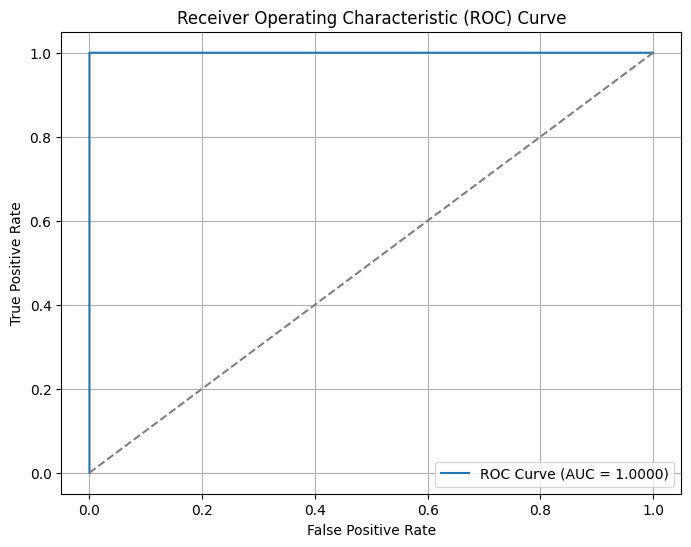

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_latent, meta_clf.predict_proba(test_meta_features)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()